# HOMEWORK 4

For this homework you are going to implement a lane line detector. Lane line detection is crucial for ADAS (Advanced Driver Assistance Systems) systems and, in particular, for LKA (Lane Keep Assist). You will use a picture from a front facing camera (mounted on the car) and will implement the following steps:
* Convert image to gray scale
* Compute edge map
* Apply Hough transform to obtain line parametrizations

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load and show the camera frame.

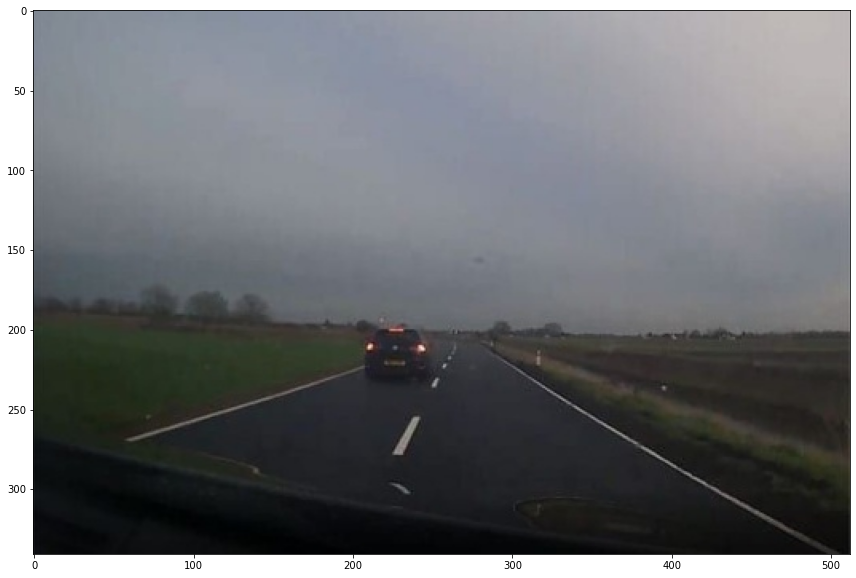

In [2]:
img = cv2.imread('data/dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [3]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [4]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, threshold1=100, threshold2=150)

(<AxesSubplot:title={'center':'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

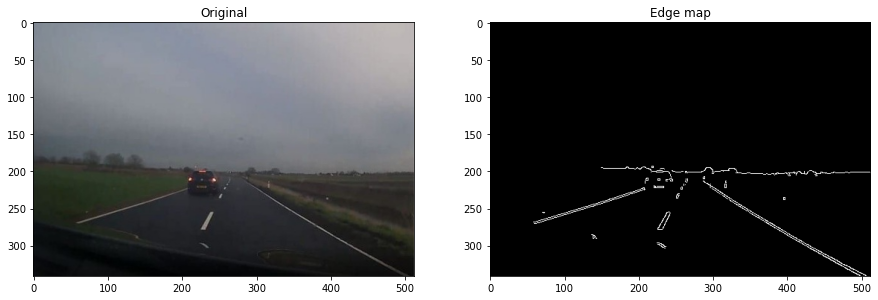

In [5]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [6]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 5 pixels and slope resolution of 5 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 90
lines = cv2.HoughLines(edges, rho=5, theta=5*np.pi/180, threshold=90)
# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

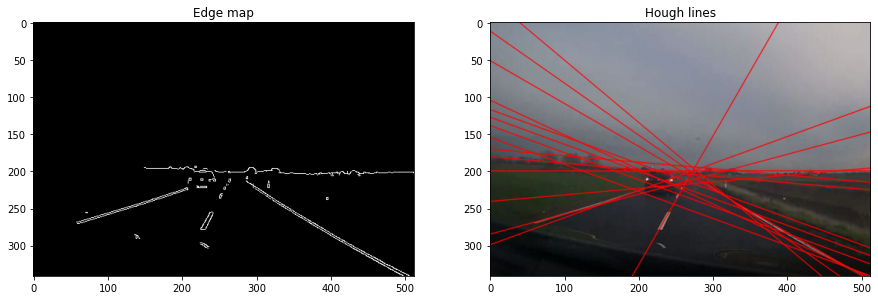

In [7]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The edge map looks good but the Hough lines are too noisy. Let's clean the Hough lines first by removing all lines that we know cannot represent a lane line. In other words, all lines that are approximately horizontal shall be removed. Remember that horizontal lines correspond to theta = 90 degrees.

In [8]:
# Filter out all lines that are approximately horizontal (+/- 15 degrees). 
filtered_lines = []
for line in lines:
    # Extract theta for current line (remember Hough works with radians)
    theta = line[1]
    # Keep line if theta is not horizontal
    if (theta<=(75*np.pi/180) or theta>=(105*np.pi/180)):
        filtered_lines.append(line)

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

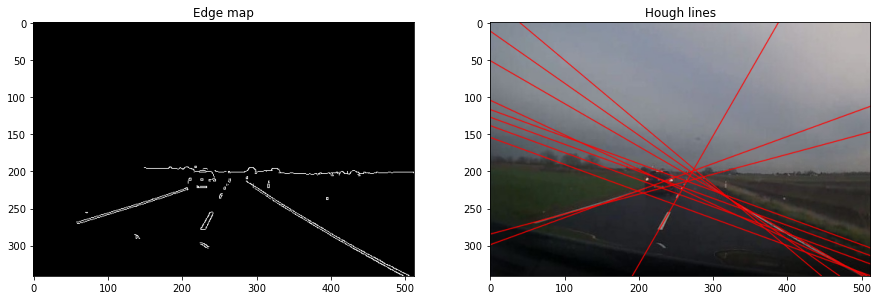

In [9]:
# Let's plot the resulting filtered lines
result = np.copy(img)
 
for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

The result is now much better, but still we see some very similar lines. How can we get rid of them?
* Let's apply k-means clustering. It will find the clusters of the 3 lines and use the averages.

In [10]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(filtered_lines)
kmeans.cluster_centers_

array([[120.        ,   1.93731542],
       [296.66666667,   1.01810873],
       [ 10.        ,   2.18166161]])

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

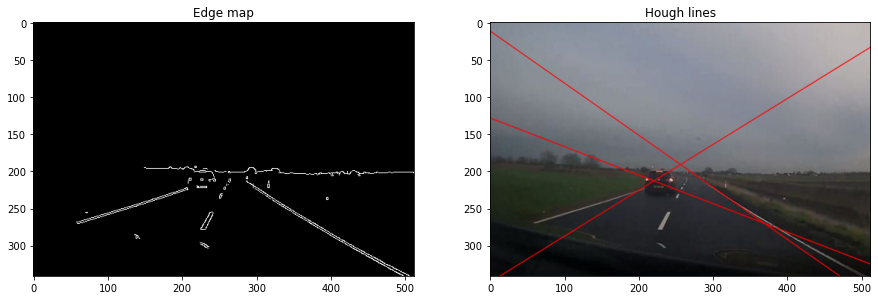

In [11]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

### Questions
* Do you see anything strange in the final result?

*Не различаются границы полос движения(только дорога целиком). Для дорог где существует встречное движение - важно также  различать полосы.*

* Do you think the Hough transform resolution is important for obtaining a good result? Why?

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

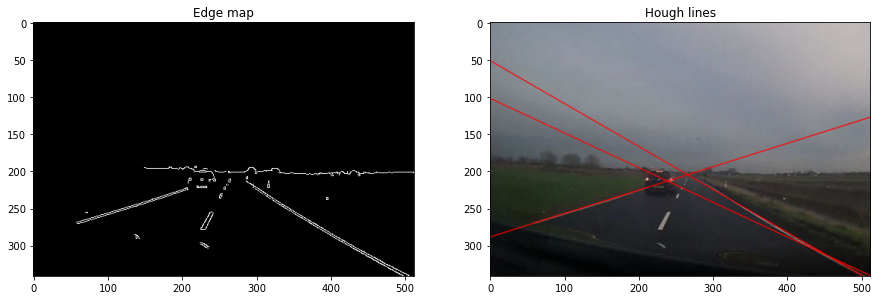

In [12]:
lines = cv2.HoughLines(edges, rho=2, theta=5*np.pi/180, threshold=90)
lines = lines[:, 0, :]

filtered_lines = []
for line in lines:
    theta = line[1]
    if (theta<=(75*np.pi/180) or theta>=(105*np.pi/180)):
        filtered_lines.append(line)
        
kmeans = KMeans(n_clusters=3).fit(filtered_lines)
kmeans.cluster_centers_

result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

*Значение resolution влияет на результат. На картинке выше выбрано значение rho=2(не 5) и результат улучшился, лучшее попадание в границы дороги. Для функции `cv2.HoughLines()` важно подобрать оптимальные параметры*

* Do you think the Hough transform accumulator threshold is important for obtaining a good result? Why?

(<AxesSubplot:title={'center':'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

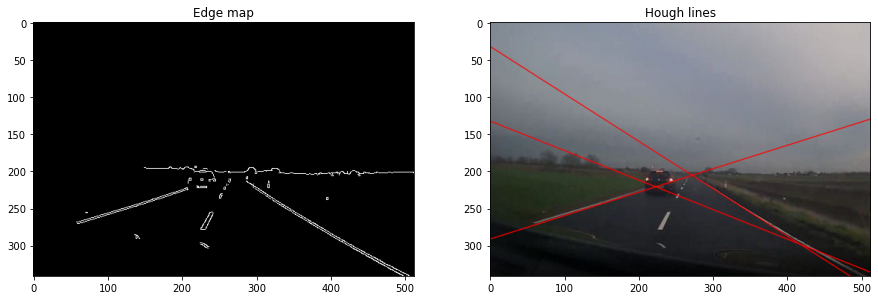

In [13]:
lines = cv2.HoughLines(edges, rho=5, theta=5*np.pi/180, threshold=100)
lines = lines[:, 0, :]

filtered_lines = []
for line in lines:
    theta = line[1]
    if (theta<=(75*np.pi/180) or theta>=(105*np.pi/180)):
        filtered_lines.append(line)
        
kmeans = KMeans(n_clusters=3).fit(filtered_lines)
kmeans.cluster_centers_

result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho = line[0]
    theta = line[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

*Значение `accumulator threshold` влияет на результат. На картинке выше выбрано значение `threshold=100`(не 90) и результат улучшился, но при дальнейшем увеличении результат не улучшается. Поэтому существует оптимальное значение для конкретной задачи.*